# Data Preparation v6 - Paris Analysis (Simplified)

**Objective:** Prepare datasets for gentrification analysis focused on IRIS type H (habitat)

**Steps:**
1. Load all datasets
2. Map IRIS types to each dataset
3. Verify suppression codes in FILOSOFI, EDUCATION, CENSUS
4. Investigate FILOSOFI issues by IRIS type
5. Clean DVF with outlier removal
6. Save cleaned datasets

## 1. Setup & Data Loading

In [1]:
# Imports
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Config
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

DATASETS_DIR = Path('../datasets')

print("Setup complete!")

Setup complete!


In [2]:
# Load all datasets
print("Loading datasets...\n")

# FILOSOFI
filosofi_2013 = pd.read_parquet(DATASETS_DIR / 'filosofi_2013_paris.parquet')
filosofi_2017 = pd.read_parquet(DATASETS_DIR / 'filosofi_2017_paris.parquet')
filosofi_2021 = pd.read_parquet(DATASETS_DIR / 'filosofi_2021_paris.parquet')
print(f"✓ FILOSOFI: {len(filosofi_2013)}, {len(filosofi_2017)}, {len(filosofi_2021)} rows")

# EDUCATION
education_2013 = pd.read_parquet(DATASETS_DIR / 'education_2013_paris.parquet')
education_2017 = pd.read_parquet(DATASETS_DIR / 'education_2017_paris.parquet')
education_2021 = pd.read_parquet(DATASETS_DIR / 'education_2021_paris.parquet')
print(f"✓ EDUCATION: {len(education_2013)}, {len(education_2017)}, {len(education_2021)} rows")

# CENSUS
census_2013 = pd.read_parquet(DATASETS_DIR / 'census_2013_paris.parquet')
census_2017 = pd.read_parquet(DATASETS_DIR / 'census_2017_paris.parquet')
census_2021 = pd.read_parquet(DATASETS_DIR / 'census_2021_paris.parquet')
print(f"✓ CENSUS: {len(census_2013)}, {len(census_2017)}, {len(census_2021)} rows")

# DVF (load as GeoDataFrame to preserve geometry)
dvf_mutations = gpd.read_parquet(DATASETS_DIR / 'dvf_mutations_paris.parquet')
print(f"✓ DVF: {len(dvf_mutations)} transactions")
print(f"  Geometry type: {dvf_mutations.geometry.geom_type.value_counts().to_dict() if hasattr(dvf_mutations, 'geometry') else 'No geometry'}")

# IRIS GeoJSON (for type mapping)
iris_geo = gpd.read_file(DATASETS_DIR / 'iris_paris.geojson')
print(f"✓ IRIS: {len(iris_geo)} zones")

print(f"\nAll datasets loaded!")

Loading datasets...

✓ FILOSOFI: 853, 871, 992 rows
✓ EDUCATION: 992, 992, 992 rows
✓ CENSUS: 992, 992, 992 rows
✓ DVF: 457097 transactions
  Geometry type: {'MultiPolygon': 456962}
✓ IRIS: 992 zones

All datasets loaded!
✓ DVF: 457097 transactions
  Geometry type: {'MultiPolygon': 456962}
✓ IRIS: 992 zones

All datasets loaded!


## 2. IRIS Type Mapping

Create a mapping of IRIS codes to their types (H=Habitat, D=Divers, A=Activité).
Analysis will focus on type **H** only.

In [3]:
# Create IRIS type reference
iris_types = iris_geo[['code_iris', 'typ_iris']].copy()
iris_types['code_iris'] = iris_types['code_iris'].astype(str)

print("IRIS Type Distribution:")
print(iris_types['typ_iris'].value_counts())
print(f"\nTotal IRIS: {len(iris_types)}")
print(f"Type H (Habitat): {(iris_types['typ_iris'] == 'H').sum()}")
print(f"Type D (Divers): {(iris_types['typ_iris'] == 'D').sum()}")
print(f"Type A (Activité): {(iris_types['typ_iris'] == 'A').sum()}")

print("\n→ Analysis will focus on Type H (Habitat) only")

IRIS Type Distribution:
typ_iris
H    861
A     88
D     43
Name: count, dtype: int64

Total IRIS: 992
Type H (Habitat): 861
Type D (Divers): 43
Type A (Activité): 88

→ Analysis will focus on Type H (Habitat) only


## 3. FILOSOFI - Verification & Cleaning

**Known issues:**
- 2017: 1 NaN value in median_uc
- 2021: Several suppression codes in median_uc

**Action:** Investigate which IRIS types are affected

In [4]:
# Helper function to detect suppression codes
def detect_suppression_codes(series, codes=['ns', 'nd', 's', 'c', '/', '-', 'NA']):
    """Detect suppression codes (case insensitive)"""
    series_str = series.astype(str).str.strip().str.lower()
    codes_lower = [str(c).lower() for c in codes]
    return series_str.isin(codes_lower)

print("Checking FILOSOFI datasets for issues...\n")

# FILOSOFI 2013
print("="*60)
print("FILOSOFI 2013")
print("="*60)
print(f"Rows: {len(filosofi_2013)}")
print(f"Data type of median_uc: {filosofi_2013['median_uc'].dtype}")
print(f"Missing values: {filosofi_2013['median_uc'].isna().sum()}")
suppression = detect_suppression_codes(filosofi_2013['median_uc'])
print(f"Suppression codes: {suppression.sum()}")
print("✓ No issues detected\n")

# FILOSOFI 2017
print("="*60)
print("FILOSOFI 2017")
print("="*60)
print(f"Rows: {len(filosofi_2017)}")
print(f"Data type of median_uc: {filosofi_2017['median_uc'].dtype}")
print(f"Missing values: {filosofi_2017['median_uc'].isna().sum()}")
suppression = detect_suppression_codes(filosofi_2017['median_uc'])
print(f"Suppression codes: {suppression.sum()}")

# Map with IRIS types and investigate
filosofi_2017_check = filosofi_2017.copy()
filosofi_2017_check['code_iris'] = filosofi_2017_check['code_iris'].astype(str)
filosofi_2017_check = filosofi_2017_check.merge(iris_types, on='code_iris', how='left')

nan_rows = filosofi_2017_check[filosofi_2017_check['median_uc'].isna()]
print(f"\nNaN value investigation:")
if len(nan_rows) > 0:
    print(f"  IRIS with NaN: {nan_rows['code_iris'].values}")
    print(f"  IRIS type: {nan_rows['typ_iris'].values}")
    print(f"  → Impact on type H: {'YES' if (nan_rows['typ_iris'] == 'H').any() else 'NO'}")
print()

# FILOSOFI 2021
print("="*60)
print("FILOSOFI 2021")
print("="*60)
print(f"Rows: {len(filosofi_2021)}")
print(f"Data type of median_uc: {filosofi_2021['median_uc'].dtype}")
print(f"Missing values: {filosofi_2021['median_uc'].isna().sum()}")
suppression = detect_suppression_codes(filosofi_2021['median_uc'])
print(f"Suppression codes: {suppression.sum()}")

# Map with IRIS types and investigate
filosofi_2021_check = filosofi_2021.copy()
filosofi_2021_check['code_iris'] = filosofi_2021_check['code_iris'].astype(str)
filosofi_2021_check = filosofi_2021_check.merge(iris_types, on='code_iris', how='left')

supp_rows = filosofi_2021_check[detect_suppression_codes(filosofi_2021_check['median_uc'])]
print(f"\nSuppression codes investigation:")
if len(supp_rows) > 0:
    print(f"  Total IRIS with suppression: {len(supp_rows)}")
    print(f"  Suppression codes found: {supp_rows['median_uc'].unique()}")
    print(f"\n  By IRIS type:")
    print(supp_rows['typ_iris'].value_counts())
    print(f"\n  → Type H affected: {(supp_rows['typ_iris'] == 'H').sum()} IRIS")
    print(f"  → Type D affected: {(supp_rows['typ_iris'] == 'D').sum()} IRIS")
    print(f"  → Type A affected: {(supp_rows['typ_iris'] == 'A').sum()} IRIS")

Checking FILOSOFI datasets for issues...

FILOSOFI 2013
Rows: 853
Data type of median_uc: float64
Missing values: 0
Suppression codes: 0
✓ No issues detected

FILOSOFI 2017
Rows: 871
Data type of median_uc: float64
Missing values: 1
Suppression codes: 0

NaN value investigation:
  IRIS with NaN: ['751145625']
  IRIS type: ['A']
  → Impact on type H: NO

FILOSOFI 2021
Rows: 992
Data type of median_uc: object
Missing values: 0
Suppression codes: 128

Suppression codes investigation:
  Total IRIS with suppression: 128
  Suppression codes found: ['ns' 'nd']

  By IRIS type:
typ_iris
A    76
D    43
H     9
Name: count, dtype: int64

  → Type H affected: 9 IRIS
  → Type D affected: 43 IRIS
  → Type A affected: 76 IRIS


### FILOSOFI Cleaning Decision

Based on investigation above:
- Keep all FILOSOFI data for now
- Filter for type H during analysis phase
- Convert median_uc to numeric (NaN and suppression codes will become NaN)

In [5]:
# Clean FILOSOFI datasets
filosofi_2013_clean = filosofi_2013.copy()
filosofi_2017_clean = filosofi_2017.copy()
filosofi_2021_clean = filosofi_2021.copy()

# Convert median_uc to numeric (suppression codes → NaN)
for year, df in [(2013, filosofi_2013_clean), (2017, filosofi_2017_clean), (2021, filosofi_2021_clean)]:
    df['median_uc'] = pd.to_numeric(df['median_uc'], errors='coerce')
    df['code_iris'] = df['code_iris'].astype(str)
    df['annee'] = year
    print(f"FILOSOFI {year}: median_uc converted, {df['median_uc'].isna().sum()} NaN values")

print("\n✓ FILOSOFI cleaned")

FILOSOFI 2013: median_uc converted, 0 NaN values
FILOSOFI 2017: median_uc converted, 1 NaN values
FILOSOFI 2021: median_uc converted, 128 NaN values

✓ FILOSOFI cleaned


## 4. EDUCATION - Simple Verification

**Note:** For 2017 and 2021, only `pop_bac_sup` column will be kept (subdivisions pop_bac2, pop_bac34, pop_bac5_plus removed).  
This ensures consistency across all years (2013 only has pop_bac_sup).

In [6]:
print("Checking EDUCATION datasets...\n")

for year, df in [(2013, education_2013), (2017, education_2017), (2021, education_2021)]:
    print(f"EDUCATION {year}:")
    print(f"  Rows: {len(df)}")
    print(f"  Columns: {list(df.columns)}")
    
    # Check for suppression codes in pop_bac_sup
    supp = detect_suppression_codes(df['pop_bac_sup'])
    if supp.sum() > 0:
        print(f"  pop_bac_sup: {supp.sum()} suppression codes")
    else:
        print(f"  ✓ No suppression codes detected in pop_bac_sup")
    print()

# Simple cleaning: keep only code_iris and pop_bac_sup, convert to numeric, add year
print("Cleaning EDUCATION datasets...")

# 2013: already has only code_iris and pop_bac_sup
education_2013_clean = education_2013[['code_iris', 'pop_bac_sup']].copy()
education_2013_clean['code_iris'] = education_2013_clean['code_iris'].astype(str)
education_2013_clean['pop_bac_sup'] = pd.to_numeric(education_2013_clean['pop_bac_sup'], errors='coerce')
education_2013_clean['annee'] = 2013
print(f"  EDUCATION 2013: kept {list(education_2013_clean.columns)}")

# 2017: keep only code_iris and pop_bac_sup (remove subdivisions)
education_2017_clean = education_2017[['code_iris', 'pop_bac_sup']].copy()
education_2017_clean['code_iris'] = education_2017_clean['code_iris'].astype(str)
education_2017_clean['pop_bac_sup'] = pd.to_numeric(education_2017_clean['pop_bac_sup'], errors='coerce')
education_2017_clean['annee'] = 2017
print(f"  EDUCATION 2017: kept {list(education_2017_clean.columns)} (removed pop_bac2, pop_bac34, pop_bac5_plus)")

# 2021: keep only code_iris and pop_bac_sup (remove subdivisions)
education_2021_clean = education_2021[['code_iris', 'pop_bac_sup']].copy()
education_2021_clean['code_iris'] = education_2021_clean['code_iris'].astype(str)
education_2021_clean['pop_bac_sup'] = pd.to_numeric(education_2021_clean['pop_bac_sup'], errors='coerce')
education_2021_clean['annee'] = 2021
print(f"  EDUCATION 2021: kept {list(education_2021_clean.columns)} (removed pop_bac2, pop_bac34, pop_bac5_plus)")

print("\n✓ EDUCATION cleaned (all years now have same structure: code_iris + pop_bac_sup + annee)")

Checking EDUCATION datasets...

EDUCATION 2013:
  Rows: 992
  Columns: ['code_iris', 'pop_bac_sup']
  ✓ No suppression codes detected in pop_bac_sup

EDUCATION 2017:
  Rows: 992
  Columns: ['code_iris', 'pop_bac2', 'pop_bac34', 'pop_bac5_plus', 'pop_bac_sup']
  ✓ No suppression codes detected in pop_bac_sup

EDUCATION 2021:
  Rows: 992
  Columns: ['code_iris', 'pop_bac2', 'pop_bac34', 'pop_bac5_plus', 'pop_bac_sup']
  ✓ No suppression codes detected in pop_bac_sup

Cleaning EDUCATION datasets...
  EDUCATION 2013: kept ['code_iris', 'pop_bac_sup', 'annee']
  EDUCATION 2017: kept ['code_iris', 'pop_bac_sup', 'annee'] (removed pop_bac2, pop_bac34, pop_bac5_plus)
  EDUCATION 2021: kept ['code_iris', 'pop_bac_sup', 'annee'] (removed pop_bac2, pop_bac34, pop_bac5_plus)

✓ EDUCATION cleaned (all years now have same structure: code_iris + pop_bac_sup + annee)


## 5. CENSUS - Simple Verification

In [7]:
print("Checking CENSUS datasets...\n")

for year, df in [(2013, census_2013), (2017, census_2017), (2021, census_2021)]:
    print(f"CENSUS {year}:")
    print(f"  Rows: {len(df)}")
    
    # Check numeric columns
    numeric_cols = [col for col in df.columns if col.startswith('pop_')]
    print(f"  Pop columns: {len(numeric_cols)}")
    
    # Check for suppression codes
    has_suppression = False
    for col in numeric_cols:
        supp = detect_suppression_codes(df[col])
        if supp.sum() > 0:
            print(f"    {col}: {supp.sum()} suppression codes")
            has_suppression = True
    
    if not has_suppression:
        print(f"  ✓ No suppression codes detected")
    print()

# Simple cleaning: convert to numeric, add year, create percentages
census_2013_clean = census_2013.copy()
census_2017_clean = census_2017.copy()
census_2021_clean = census_2021.copy()

for year, df in [(2013, census_2013_clean), (2017, census_2017_clean), (2021, census_2021_clean)]:
    df['code_iris'] = df['code_iris'].astype(str)
    df['annee'] = year
    numeric_cols = [col for col in df.columns if col.startswith('pop_')]
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Create percentage variables
    df['pct_cadres'] = (df['pop_cadres'] / df['pop_15plus']) * 100
    df['pct_immigres'] = (df['pop_immigres'] / df['pop_total']) * 100
    df['pct_ouvriers'] = (df['pop_ouvriers'] / df['pop_15plus']) * 100
    df['pct_25_39'] = (df['pop_25_39'] / df['pop_total']) * 100
    df['pct_65plus'] = (df['pop_65plus'] / df['pop_total']) * 100

print("✓ CENSUS cleaned")

Checking CENSUS datasets...

CENSUS 2013:
  Rows: 992
  Pop columns: 11


  ✓ No suppression codes detected

CENSUS 2017:
  Rows: 992
  Pop columns: 11
  ✓ No suppression codes detected

CENSUS 2021:
  Rows: 992
  Pop columns: 11
  ✓ No suppression codes detected

✓ CENSUS cleaned


## 6. DVF - Cleaning with Outlier Removal

**Steps:**
1. Convert datemut to datetime
2. Filter property types (apartments and houses)
3. Remove outliers in valeurfonc and sbati
4. Create prix_m2
5. Remove outliers in prix_m2 (IQR method)
6. Create simplified property type

In [8]:
print("DVF Cleaning...\n")

# Keep as GeoDataFrame to preserve geometry
dvf_clean = dvf_mutations.copy()
print(f"Initial: {len(dvf_clean):,} transactions")
if 'geometry' in dvf_clean.columns:
    print(f"Geometry column present: {dvf_clean.geometry.notna().sum()} parcels")

# 1. Convert date
dvf_clean['datemut'] = pd.to_datetime(dvf_clean['datemut'], errors='coerce')

# 2. Filter property types
valid_types = ["UN APPARTEMENT", "DEUX APPARTEMENTS", "APPARTEMENT INDETERMINE", "UNE MAISON"]
dvf_clean = dvf_clean[dvf_clean['libtypbien'].isin(valid_types)].copy()
print(f"After property type filter: {len(dvf_clean):,} transactions")

# 3. Convert to numeric and remove basic outliers
dvf_clean['valeurfonc'] = pd.to_numeric(dvf_clean['valeurfonc'], errors='coerce')
dvf_clean['sbati'] = pd.to_numeric(dvf_clean['sbati'], errors='coerce')

# Remove extreme values
dvf_clean = dvf_clean[
    (dvf_clean['valeurfonc'] >= 10_000) & 
    (dvf_clean['valeurfonc'] <= 10_000_000) &
    (dvf_clean['sbati'] >= 9) & 
    (dvf_clean['sbati'] <= 500)
].copy()
print(f"After outlier removal: {len(dvf_clean):,} transactions")

# Remove missing values
dvf_clean = dvf_clean.dropna(subset=['valeurfonc', 'sbati']).copy()
print(f"After removing NaN: {len(dvf_clean):,} transactions")

# 4. Create prix_m2
dvf_clean['prix_m2'] = dvf_clean['valeurfonc'] / dvf_clean['sbati']

# 5. Remove outliers in prix_m2 (IQR method)
Q1 = dvf_clean['prix_m2'].quantile(0.25)
Q3 = dvf_clean['prix_m2'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

dvf_clean = dvf_clean[
    (dvf_clean['prix_m2'] >= lower_bound) & 
    (dvf_clean['prix_m2'] <= upper_bound)
].copy()
print(f"After prix_m2 outlier removal: {len(dvf_clean):,} transactions")
print(f"Prix m² range: {dvf_clean['prix_m2'].min():.0f} - {dvf_clean['prix_m2'].max():.0f} EUR/m²")

# 6. Create simplified property type
type_mapping = {
    "UN APPARTEMENT": "Appartement",
    "DEUX APPARTEMENTS": "Appartement",
    "APPARTEMENT INDETERMINE": "Appartement",
    "UNE MAISON": "Maison"
}
dvf_clean['type_bien_simplifie'] = dvf_clean['libtypbien'].map(type_mapping)

# 7. Verify geometry is preserved
if 'geometry' in dvf_clean.columns:
    print(f"\n✓ Geometry preserved: {dvf_clean.geometry.notna().sum()} parcels ({dvf_clean.geometry.notna().sum()/len(dvf_clean)*100:.1f}%)")

print("\n✓ DVF cleaned")
print(f"\nFinal statistics:")
print(f"  Mean prix_m2: {dvf_clean['prix_m2'].mean():,.0f} EUR/m²")
print(f"  Median prix_m2: {dvf_clean['prix_m2'].median():,.0f} EUR/m²")
print(f"\nBy property type:")
print(dvf_clean.groupby('type_bien_simplifie')['prix_m2'].agg(['count', 'mean', 'median']))

DVF Cleaning...

Initial: 457,097 transactions
Initial: 457,097 transactions


Geometry column present: 456962 parcels
After property type filter: 354,992 transactions
After property type filter: 354,992 transactions
After outlier removal: 346,045 transactions
After removing NaN: 346,045 transactions
After prix_m2 outlier removal: 329,036 transactions
Prix m² range: 2433 - 16674 EUR/m²
After outlier removal: 346,045 transactions
After removing NaN: 346,045 transactions
After prix_m2 outlier removal: 329,036 transactions
Prix m² range: 2433 - 16674 EUR/m²

✓ Geometry preserved: 328988 parcels (100.0%)

✓ DVF cleaned

Final statistics:
  Mean prix_m2: 9,515 EUR/m²
  Median prix_m2: 9,441 EUR/m²

By property type:
                      count     mean   median
type_bien_simplifie                          
Appartement          327908  9508.65  9433.96
Maison                 1128 11284.56 11354.54

✓ Geometry preserved: 328988 parcels (100.0%)

✓ DVF cleaned

Final statistics:
  Mean prix_m2: 9,515 EUR/m²
  Median prix_m2: 9,441 EUR/m²

By property type:
              

### DVF Visualization

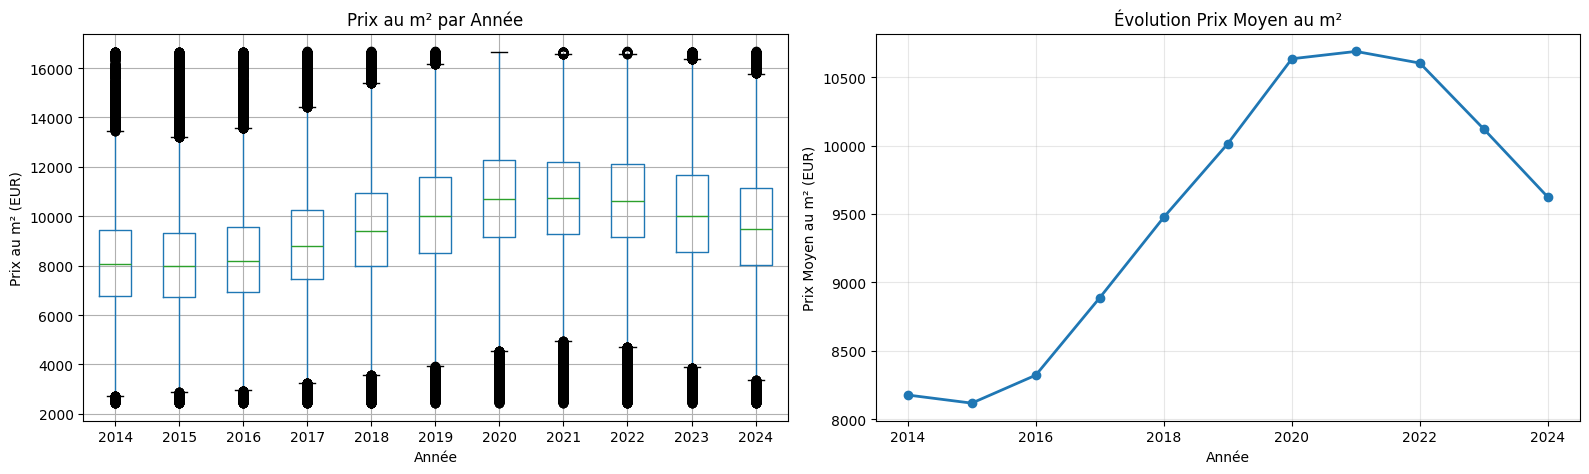

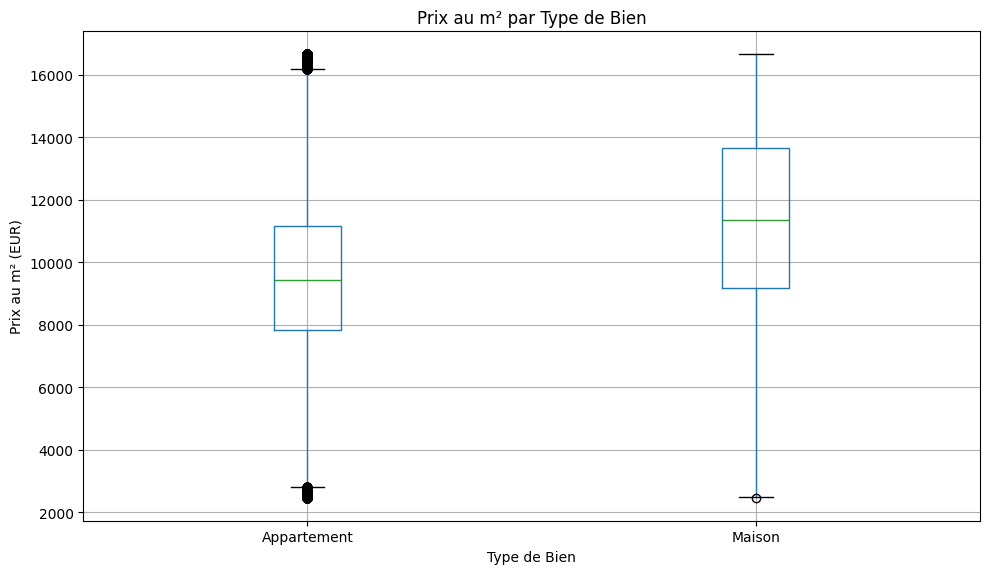

In [9]:
# Prix m² evolution by year
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Boxplot by year
dvf_clean.boxplot(column='prix_m2', by='anneemut', ax=axes[0])
axes[0].set_title('Prix au m² par Année')
axes[0].set_xlabel('Année')
axes[0].set_ylabel('Prix au m² (EUR)')

# Mean evolution
mean_by_year = dvf_clean.groupby('anneemut')['prix_m2'].mean()
axes[1].plot(mean_by_year.index, mean_by_year.values, marker='o', linewidth=2)
axes[1].set_title('Évolution Prix Moyen au m²')
axes[1].set_xlabel('Année')
axes[1].set_ylabel('Prix Moyen au m² (EUR)')
axes[1].grid(True, alpha=0.3)

plt.suptitle('')
plt.tight_layout()
plt.show()

# By property type
fig, ax = plt.subplots(figsize=(10, 6))
dvf_clean.boxplot(column='prix_m2', by='type_bien_simplifie', ax=ax)
ax.set_title('Prix au m² par Type de Bien')
ax.set_xlabel('Type de Bien')
ax.set_ylabel('Prix au m² (EUR)')
plt.suptitle('')
plt.tight_layout()
plt.show()

## 7. Agrégation par Quartier

Créer des datasets agrégés au niveau quartier en regroupant les IRIS.
Le nom du quartier est extrait de `nom_iris` en enlevant le numéro final.

### 7.1 Création du mapping IRIS → Quartier

In [10]:
print("Creating IRIS → Quartier mapping...\n")

# Extract quartier name from nom_iris (remove final number)
iris_quartier_mapping = iris_geo[['code_iris', 'nom_iris', 'typ_iris']].copy()
iris_quartier_mapping['code_iris'] = iris_quartier_mapping['code_iris'].astype(str)
iris_quartier_mapping['quartier'] = iris_quartier_mapping['nom_iris'].str.replace(r'\s+\d+$', '', regex=True).str.strip()

print(f"Total IRIS: {len(iris_quartier_mapping)}")
print(f"Unique quartiers: {iris_quartier_mapping['quartier'].nunique()}")

# Count IRIS types per quartier
quartier_iris_types = iris_quartier_mapping.groupby('quartier')['typ_iris'].value_counts().unstack(fill_value=0)
quartier_iris_types = quartier_iris_types.rename(columns={'H': 'n_iris_H', 'D': 'n_iris_D', 'A': 'n_iris_A'})
quartier_iris_types['n_iris_total'] = quartier_iris_types.sum(axis=1)

# Ensure all columns exist (in case some quartiers have no D or A)
for col in ['n_iris_H', 'n_iris_D', 'n_iris_A']:
    if col not in quartier_iris_types.columns:
        quartier_iris_types[col] = 0

quartier_iris_types = quartier_iris_types.reset_index()

# Calculate percentages
quartier_iris_types['pct_H'] = (quartier_iris_types['n_iris_H'] / quartier_iris_types['n_iris_total']) * 100
quartier_iris_types['pct_D'] = (quartier_iris_types['n_iris_D'] / quartier_iris_types['n_iris_total']) * 100
quartier_iris_types['pct_A'] = (quartier_iris_types['n_iris_A'] / quartier_iris_types['n_iris_total']) * 100

# Classify quartier type based on composition:
# - If >50% H → "Habitation"
# - Else if D > A → "Divers" 
# - Else → "Activité"
def classify_quartier(row):
    if row['pct_H'] > 50:
        return 'Habitation'
    elif row['n_iris_D'] > row['n_iris_A']:
        return 'Divers'
    else:
        return 'Activité'

quartier_iris_types['type_quartier'] = quartier_iris_types.apply(classify_quartier, axis=1)

print(f"\nQuartier IRIS type distribution:")
print(f"  Mean IRIS per quartier: {quartier_iris_types['n_iris_total'].mean():.1f}")
print(f"  Max IRIS per quartier: {quartier_iris_types['n_iris_total'].max()}")
print(f"  Min IRIS per quartier: {quartier_iris_types['n_iris_total'].min()}")

print(f"\nQuartier classification by dominant type:")
print(quartier_iris_types['type_quartier'].value_counts())

print("\nTop 10 quartiers by total IRIS:")
print(quartier_iris_types.nlargest(10, 'n_iris_total')[['quartier', 'n_iris_H', 'n_iris_D', 'n_iris_A', 'n_iris_total', 'pct_H', 'type_quartier']])

print("\n✓ Quartier mapping created with classification")

Creating IRIS → Quartier mapping...

Total IRIS: 992
Unique quartiers: 94

Quartier IRIS type distribution:
  Mean IRIS per quartier: 10.6
  Max IRIS per quartier: 33
  Min IRIS per quartier: 1

Quartier classification by dominant type:
type_quartier
Habitation    71
Divers        14
Activité       9
Name: count, dtype: int64

Top 10 quartiers by total IRIS:
typ_iris           quartier  n_iris_H  n_iris_D  n_iris_A  n_iris_total  \
77            Saint-Lambert        31         0         2            33   
3                   Auteuil        30         0         1            31   
32                     Gare        30         0         1            31   
34        Grandes Carrières        28         0         1            29   
22             Clignancourt        27         0         0            27   
20                 Charonne        26         0         0            26   
0                  Amérique        24         0         1            25   
48           Maison Blanche        25  

### 7.2 FILOSOFI - Agrégation par Quartier

In [11]:
print("Aggregating FILOSOFI by quartier...\n")

# Aggregate FILOSOFI datasets by quartier
filosofi_quartier_list = []

for year, df in [(2013, filosofi_2013_clean), (2017, filosofi_2017_clean), (2021, filosofi_2021_clean)]:
    # Merge with quartier mapping
    df_with_quartier = df.merge(iris_quartier_mapping[['code_iris', 'quartier']], on='code_iris', how='left')
    
    # Aggregate: median income per quartier
    df_quartier = df_with_quartier.groupby('quartier').agg({
        'median_uc': 'median',  # Median of medians
        'code_iris': 'count'    # Number of IRIS
    }).reset_index()
    
    df_quartier = df_quartier.rename(columns={'code_iris': 'n_iris'})
    df_quartier['annee'] = year
    
    filosofi_quartier_list.append(df_quartier)
    print(f"  FILOSOFI {year}: {len(df_quartier)} quartiers")

# Combine all years
filosofi_quartier_clean = pd.concat(filosofi_quartier_list, ignore_index=True)

# Merge with quartier IRIS type counts
filosofi_quartier_clean = filosofi_quartier_clean.merge(
    quartier_iris_types[['quartier', 'n_iris_H', 'n_iris_D', 'n_iris_A', 'n_iris_total']], 
    on='quartier', 
    how='left'
)

print(f"\n✓ FILOSOFI quartier aggregation complete")
print(f"  Total rows: {len(filosofi_quartier_clean)}")
print(f"  Columns: {list(filosofi_quartier_clean.columns)}")
print(f"\nSample:")
print(filosofi_quartier_clean.head())

Aggregating FILOSOFI by quartier...

  FILOSOFI 2013: 76 quartiers
  FILOSOFI 2017: 77 quartiers
  FILOSOFI 2021: 94 quartiers

✓ FILOSOFI quartier aggregation complete
  Total rows: 247
  Columns: ['quartier', 'median_uc', 'n_iris', 'annee', 'n_iris_H', 'n_iris_D', 'n_iris_A', 'n_iris_total']

Sample:
          quartier  median_uc  n_iris  annee  n_iris_H  n_iris_D  n_iris_A  \
0         Amérique   20614.11      24   2013        24         0         1   
1          Arsenal   33392.71       4   2013         4         0         0   
2  Arts et Métiers   27563.00       5   2013         5         0         0   
3          Auteuil   37822.40      30   2013        30         0         1   
4      Batignolles   33004.00      16   2013        16         0         0   

   n_iris_total  
0            25  
1             4  
2             5  
3            31  
4            16  


### 7.3 EDUCATION - Agrégation par Quartier

In [12]:
print("Aggregating EDUCATION by quartier...\n")

# Aggregate EDUCATION datasets by quartier
education_quartier_list = []

for year, df in [(2013, education_2013_clean), (2017, education_2017_clean), (2021, education_2021_clean)]:
    # Merge with quartier mapping
    df_with_quartier = df.merge(iris_quartier_mapping[['code_iris', 'quartier']], on='code_iris', how='left')
    
    # Aggregate: sum population with bac+
    df_quartier = df_with_quartier.groupby('quartier').agg({
        'pop_bac_sup': 'sum',   # Sum of populations
        'code_iris': 'count'    # Number of IRIS
    }).reset_index()
    
    df_quartier = df_quartier.rename(columns={'code_iris': 'n_iris'})
    df_quartier['annee'] = year
    
    education_quartier_list.append(df_quartier)
    print(f"  EDUCATION {year}: {len(df_quartier)} quartiers")

# Combine all years
education_quartier_clean = pd.concat(education_quartier_list, ignore_index=True)

# Merge with quartier IRIS type counts
education_quartier_clean = education_quartier_clean.merge(
    quartier_iris_types[['quartier', 'n_iris_H', 'n_iris_D', 'n_iris_A', 'n_iris_total']], 
    on='quartier', 
    how='left'
)

print(f"\n✓ EDUCATION quartier aggregation complete")
print(f"  Total rows: {len(education_quartier_clean)}")
print(f"  Columns: {list(education_quartier_clean.columns)}")
print(f"\nSample:")
print(education_quartier_clean.head())

Aggregating EDUCATION by quartier...

  EDUCATION 2013: 94 quartiers
  EDUCATION 2017: 94 quartiers
  EDUCATION 2021: 94 quartiers

✓ EDUCATION quartier aggregation complete
  Total rows: 282
  Columns: ['quartier', 'pop_bac_sup', 'n_iris', 'annee', 'n_iris_H', 'n_iris_D', 'n_iris_A', 'n_iris_total']

Sample:
              quartier  pop_bac_sup  n_iris  annee  n_iris_H  n_iris_D  \
0             Amérique     16904.38      25   2013        24         0   
1              Arsenal      4084.70       4   2013         4         0   
2      Arts et Métiers      4756.00       5   2013         5         0   
3              Auteuil     33696.65      31   2013        30         0   
4  Bassin de l'Arsenal         0.00       2   2013         0         2   

   n_iris_A  n_iris_total  
0         1            25  
1         0             4  
2         0             5  
3         1            31  
4         0             2  


### 7.4 CENSUS - Agrégation par Quartier

In [13]:
print("Aggregating CENSUS by quartier...\n")

# Aggregate CENSUS datasets by quartier
census_quartier_list = []

for year, df in [(2013, census_2013_clean), (2017, census_2017_clean), (2021, census_2021_clean)]:
    # Merge with quartier mapping
    df_with_quartier = df.merge(iris_quartier_mapping[['code_iris', 'quartier']], on='code_iris', how='left')
    
    # Aggregate: sum all population columns
    df_quartier = df_with_quartier.groupby('quartier').agg({
        'pop_total': 'sum',
        'pop_cadres': 'sum',
        'pop_ouvriers': 'sum',
        'pop_25_39': 'sum',
        'pop_65plus': 'sum',
        'pop_immigres': 'sum',
        'pop_15plus': 'sum',
        'code_iris': 'count'
    }).reset_index()
    
    # Recalculate percentages from aggregated values
    df_quartier['pct_cadres'] = (df_quartier['pop_cadres'] / df_quartier['pop_15plus']) * 100
    df_quartier['pct_ouvriers'] = (df_quartier['pop_ouvriers'] / df_quartier['pop_15plus']) * 100
    df_quartier['pct_immigres'] = (df_quartier['pop_immigres'] / df_quartier['pop_total']) * 100
    df_quartier['pct_25_39'] = (df_quartier['pop_25_39'] / df_quartier['pop_total']) * 100
    df_quartier['pct_65plus'] = (df_quartier['pop_65plus'] / df_quartier['pop_total']) * 100
    
    df_quartier = df_quartier.rename(columns={'code_iris': 'n_iris'})
    df_quartier['annee'] = year
    
    census_quartier_list.append(df_quartier)
    print(f"  CENSUS {year}: {len(df_quartier)} quartiers")

# Combine all years
census_quartier_clean = pd.concat(census_quartier_list, ignore_index=True)

# Merge with quartier IRIS type counts
census_quartier_clean = census_quartier_clean.merge(
    quartier_iris_types[['quartier', 'n_iris_H', 'n_iris_D', 'n_iris_A', 'n_iris_total']], 
    on='quartier', 
    how='left'
)

print(f"\n✓ CENSUS quartier aggregation complete")
print(f"  Total rows: {len(census_quartier_clean)}")
print(f"  Columns: {list(census_quartier_clean.columns)}")
print(f"\nSample:")
print(census_quartier_clean.head())

Aggregating CENSUS by quartier...

  CENSUS 2013: 94 quartiers
  CENSUS 2017: 94 quartiers
  CENSUS 2021: 94 quartiers

✓ CENSUS quartier aggregation complete
  Total rows: 282
  Columns: ['quartier', 'pop_total', 'pop_cadres', 'pop_ouvriers', 'pop_25_39', 'pop_65plus', 'pop_immigres', 'pop_15plus', 'n_iris', 'pct_cadres', 'pct_ouvriers', 'pct_immigres', 'pct_25_39', 'pct_65plus', 'annee', 'n_iris_H', 'n_iris_D', 'n_iris_A', 'n_iris_total']

Sample:
              quartier  pop_total  pop_cadres  pop_ouvriers  pop_25_39  \
0             Amérique   57481.80     9091.50       3357.82   13509.41   
1              Arsenal    8474.82     2334.44        182.89    2214.40   
2      Arts et Métiers    9800.73     3237.21        371.21    3464.51   
3              Auteuil   72956.75    17005.25       1549.55   12839.72   
4  Bassin de l'Arsenal       0.00        0.00          0.00       0.00   

   pop_65plus  pop_immigres  pop_15plus  n_iris  pct_cadres  pct_ouvriers  \
0     7724.40      13804

### 7.5 DVF - Agrégation par Quartier

In [14]:
print("Aggregating DVF by quartier...\n")

# Load IRIS GeoJSON with quartier mapping
iris_geo_quartier = iris_geo.copy()
iris_geo_quartier['quartier'] = iris_geo_quartier['nom_iris'].str.replace(r'\s+\d+$', '', regex=True).str.strip()

# Filter DVF transactions with valid geometry
dvf_geo = dvf_clean[dvf_clean['geometry'].notna()].copy()
print(f"DVF transactions with geometry: {len(dvf_geo):,} / {len(dvf_clean):,}")

# Ensure dvf_geo is a proper GeoDataFrame with correct CRS
if not isinstance(dvf_geo, gpd.GeoDataFrame):
    # If not already a GeoDataFrame, it means geometry column exists but needs proper setup
    # First, convert WKB bytes to Shapely geometries using geopandas
    from shapely import wkb
    dvf_geo['geometry'] = dvf_geo['geometry'].apply(lambda x: wkb.loads(bytes(x)) if x is not None else None)
    dvf_geo = gpd.GeoDataFrame(dvf_geo, geometry='geometry', crs=iris_geo_quartier.crs)
else:
    # Ensure same CRS
    if dvf_geo.crs != iris_geo_quartier.crs:
        dvf_geo = dvf_geo.to_crs(iris_geo_quartier.crs)

print(f"CRS aligned: DVF={dvf_geo.crs}, IRIS={iris_geo_quartier.crs}")

# Spatial join: assign quartier to each DVF point based on IRIS polygon it falls within
print(f"Performing spatial join...")
dvf_with_quartier = gpd.sjoin(
    dvf_geo,
    iris_geo_quartier[['code_iris', 'quartier', 'typ_iris', 'geometry']],
    how='left',
    predicate='within'
)

matched = dvf_with_quartier['quartier'].notna().sum()
print(f"Transactions matched to quartiers: {matched:,} / {len(dvf_with_quartier):,} ({matched/len(dvf_with_quartier)*100:.1f}%)")

# Aggregate by quartier and year
dvf_quartier_clean = dvf_with_quartier.groupby(['quartier', 'anneemut']).agg({
    'prix_m2': ['mean', 'median', 'count'],  # Mean, median, and count of transactions
    'code_iris': 'nunique'  # Number of unique IRIS per quartier
}).reset_index()

# Flatten column names
dvf_quartier_clean.columns = ['quartier', 'annee', 'prix_m2_mean', 'prix_m2_median', 'n_transactions', 'n_iris']

# Remove rows where quartier is NaN (transactions outside IRIS zones)
dvf_quartier_clean = dvf_quartier_clean[dvf_quartier_clean['quartier'].notna()]

# Merge with quartier IRIS type counts
dvf_quartier_clean = dvf_quartier_clean.merge(
    quartier_iris_types[['quartier', 'n_iris_H', 'n_iris_D', 'n_iris_A', 'n_iris_total']], 
    on='quartier', 
    how='left'
)

print(f"\n✓ DVF quartier aggregation complete")
print(f"  Total rows: {len(dvf_quartier_clean)}")
print(f"  Columns: {list(dvf_quartier_clean.columns)}")
print(f"  Years covered: {sorted(dvf_quartier_clean['annee'].unique())}")
print(f"\nSample:")
print(dvf_quartier_clean.head())

Aggregating DVF by quartier...

DVF transactions with geometry: 328,988 / 329,036
DVF transactions with geometry: 328,988 / 329,036
CRS aligned: DVF=EPSG:4326, IRIS=EPSG:4326
Performing spatial join...
CRS aligned: DVF=EPSG:4326, IRIS=EPSG:4326
Performing spatial join...
Transactions matched to quartiers: 326,298 / 328,988 (99.2%)

✓ DVF quartier aggregation complete
  Total rows: 887
  Columns: ['quartier', 'annee', 'prix_m2_mean', 'prix_m2_median', 'n_transactions', 'n_iris', 'n_iris_H', 'n_iris_D', 'n_iris_A', 'n_iris_total']
  Years covered: [np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024)]

Sample:
   quartier  annee  prix_m2_mean  prix_m2_median  n_transactions  n_iris  \
0  Amérique   2014       6569.46         6471.99             388      24   
1  Amérique   2015       6750.66         6526.32             525      24   
2  Amérique   2016       6653.65  

### 7.6 Analyse des Quartiers Manquants - FILOSOFI 2013 vs 2017

In [15]:
print("="*80)
print("FILOSOFI QUARTIER COVERAGE ANALYSIS")
print("="*80)

# All quartiers from IRIS GeoJSON
all_quartiers = set(quartier_iris_types['quartier'])
print(f"\nTotal quartiers in Paris (from IRIS GeoJSON): {len(all_quartiers)}")

# Get quartiers present in FILOSOFI for each year
filosofi_2013_quartiers = set(filosofi_quartier_clean[filosofi_quartier_clean['annee'] == 2013]['quartier'].dropna())
filosofi_2017_quartiers = set(filosofi_quartier_clean[filosofi_quartier_clean['annee'] == 2017]['quartier'].dropna())

print(f"\nQuartiers with FILOSOFI data in 2013: {len(filosofi_2013_quartiers)}")
print(f"Quartiers with FILOSOFI data in 2017: {len(filosofi_2017_quartiers)}")

# Find missing quartiers (quartiers in IRIS but not in FILOSOFI)
missing_in_2013 = all_quartiers - filosofi_2013_quartiers
missing_in_2017 = all_quartiers - filosofi_2017_quartiers

print(f"\nQuartiers WITHOUT FILOSOFI data in 2013: {len(missing_in_2013)}")
print(f"Quartiers WITHOUT FILOSOFI data in 2017: {len(missing_in_2017)}")

# Analyze missing quartiers in 2013
if len(missing_in_2013) > 0:
    print(f"\n" + "="*80)
    print(f"FILOSOFI 2013 - MISSING QUARTIERS ({len(missing_in_2013)} quartiers)")
    print("="*80)
    missing_2013_info = quartier_iris_types[quartier_iris_types['quartier'].isin(missing_in_2013)].copy()
    missing_2013_info = missing_2013_info.sort_values('n_iris_total', ascending=False)
    print(missing_2013_info[['quartier', 'n_iris_H', 'n_iris_D', 'n_iris_A', 'n_iris_total', 'pct_H', 'type_quartier']])
    
    print(f"\nBy quartier type:")
    print(missing_2013_info['type_quartier'].value_counts())
    
    print(f"\nTotal IRIS affected:")
    print(f"  Type H: {missing_2013_info['n_iris_H'].sum()}")
    print(f"  Type D: {missing_2013_info['n_iris_D'].sum()}")
    print(f"  Type A: {missing_2013_info['n_iris_A'].sum()}")
    print(f"  Total: {missing_2013_info['n_iris_total'].sum()}")

# Analyze missing quartiers in 2017
if len(missing_in_2017) > 0:
    print(f"\n" + "="*80)
    print(f"FILOSOFI 2017 - MISSING QUARTIERS ({len(missing_in_2017)} quartiers)")
    print("="*80)
    missing_2017_info = quartier_iris_types[quartier_iris_types['quartier'].isin(missing_in_2017)].copy()
    missing_2017_info = missing_2017_info.sort_values('n_iris_total', ascending=False)
    print(missing_2017_info[['quartier', 'n_iris_H', 'n_iris_D', 'n_iris_A', 'n_iris_total', 'pct_H', 'type_quartier']])
    
    print(f"\nBy quartier type:")
    print(missing_2017_info['type_quartier'].value_counts())
    
    print(f"\nTotal IRIS affected:")
    print(f"  Type H: {missing_2017_info['n_iris_H'].sum()}")
    print(f"  Type D: {missing_2017_info['n_iris_D'].sum()}")
    print(f"  Type A: {missing_2017_info['n_iris_A'].sum()}")
    print(f"  Total: {missing_2017_info['n_iris_total'].sum()}")

# Quartiers that gained data between 2013 and 2017
gained_in_2017 = missing_in_2013 - missing_in_2017
lost_in_2017 = missing_in_2017 - missing_in_2013

if len(gained_in_2017) > 0:
    print(f"\n" + "-"*80)
    print(f"Quartiers that GAINED data in 2017: {len(gained_in_2017)}")
    print("-"*80)
    print(list(gained_in_2017))

if len(lost_in_2017) > 0:
    print(f"\n" + "-"*80)
    print(f"Quartiers that LOST data in 2017: {len(lost_in_2017)}")
    print("-"*80)
    print(list(lost_in_2017))

# Focus on HABITATION type quartiers (>50% H)
print(f"\n" + "="*80)
print(f"FOCUS: QUARTIERS TYPE HABITATION (>50% H)")
print("="*80)

habitation_quartiers = set(quartier_iris_types[quartier_iris_types['type_quartier'] == 'Habitation']['quartier'])
print(f"\nTotal quartiers type Habitation in Paris: {len(habitation_quartiers)}")

# Missing Habitation quartiers in each year
missing_habitation_2013 = habitation_quartiers - filosofi_2013_quartiers
missing_habitation_2017 = habitation_quartiers - filosofi_2017_quartiers

print(f"\nQuartiers HABITATION WITHOUT FILOSOFI data in 2013: {len(missing_habitation_2013)}")
if len(missing_habitation_2013) > 0:
    missing_hab_2013_info = quartier_iris_types[quartier_iris_types['quartier'].isin(missing_habitation_2013)].copy()
    missing_hab_2013_info = missing_hab_2013_info.sort_values('pct_H', ascending=False)
    print("\n" + "-"*80)
    print(missing_hab_2013_info[['quartier', 'n_iris_H', 'n_iris_D', 'n_iris_A', 'pct_H', 'type_quartier']])
    print(f"\nTotal IRIS Type H affected: {missing_hab_2013_info['n_iris_H'].sum()}")

print(f"\nQuartiers HABITATION WITHOUT FILOSOFI data in 2017: {len(missing_habitation_2017)}")
if len(missing_habitation_2017) > 0:
    missing_hab_2017_info = quartier_iris_types[quartier_iris_types['quartier'].isin(missing_habitation_2017)].copy()
    missing_hab_2017_info = missing_hab_2017_info.sort_values('pct_H', ascending=False)
    print("\n" + "-"*80)
    print(missing_hab_2017_info[['quartier', 'n_iris_H', 'n_iris_D', 'n_iris_A', 'pct_H', 'type_quartier']])
    print(f"\nTotal IRIS Type H affected: {missing_hab_2017_info['n_iris_H'].sum()}")

# Quartiers Habitation present in both years
habitation_in_both = habitation_quartiers - (missing_habitation_2013 | missing_habitation_2017)
print(f"\n" + "-"*80)
print(f"Quartiers HABITATION with data in BOTH 2013 and 2017: {len(habitation_in_both)}")
print(f"Coverage rate for Habitation quartiers: {len(habitation_in_both)/len(habitation_quartiers)*100:.1f}%")

print("\n" + "="*80)

FILOSOFI QUARTIER COVERAGE ANALYSIS

Total quartiers in Paris (from IRIS GeoJSON): 94

Quartiers with FILOSOFI data in 2013: 76
Quartiers with FILOSOFI data in 2017: 77

Quartiers WITHOUT FILOSOFI data in 2013: 18
Quartiers WITHOUT FILOSOFI data in 2017: 17

FILOSOFI 2013 - MISSING QUARTIERS (18 quartiers)
typ_iris                        quartier  n_iris_H  n_iris_D  n_iris_A  \
85                       Seine et Berges         0        23         0   
21                      Chaussée d'Antin         0         0         9   
46                             Madeleine         0         0         8   
75             Saint-Germain l'Auxerrois         1         0         3   
31                               Gaillon         0         0         3   
10                      Bois de Boulogne         0         3         0   
15                    Canal Saint-Martin         0         2         0   
4                    Bassin de l'Arsenal         0         2         0   
11                     Boi


Creating visualizations...



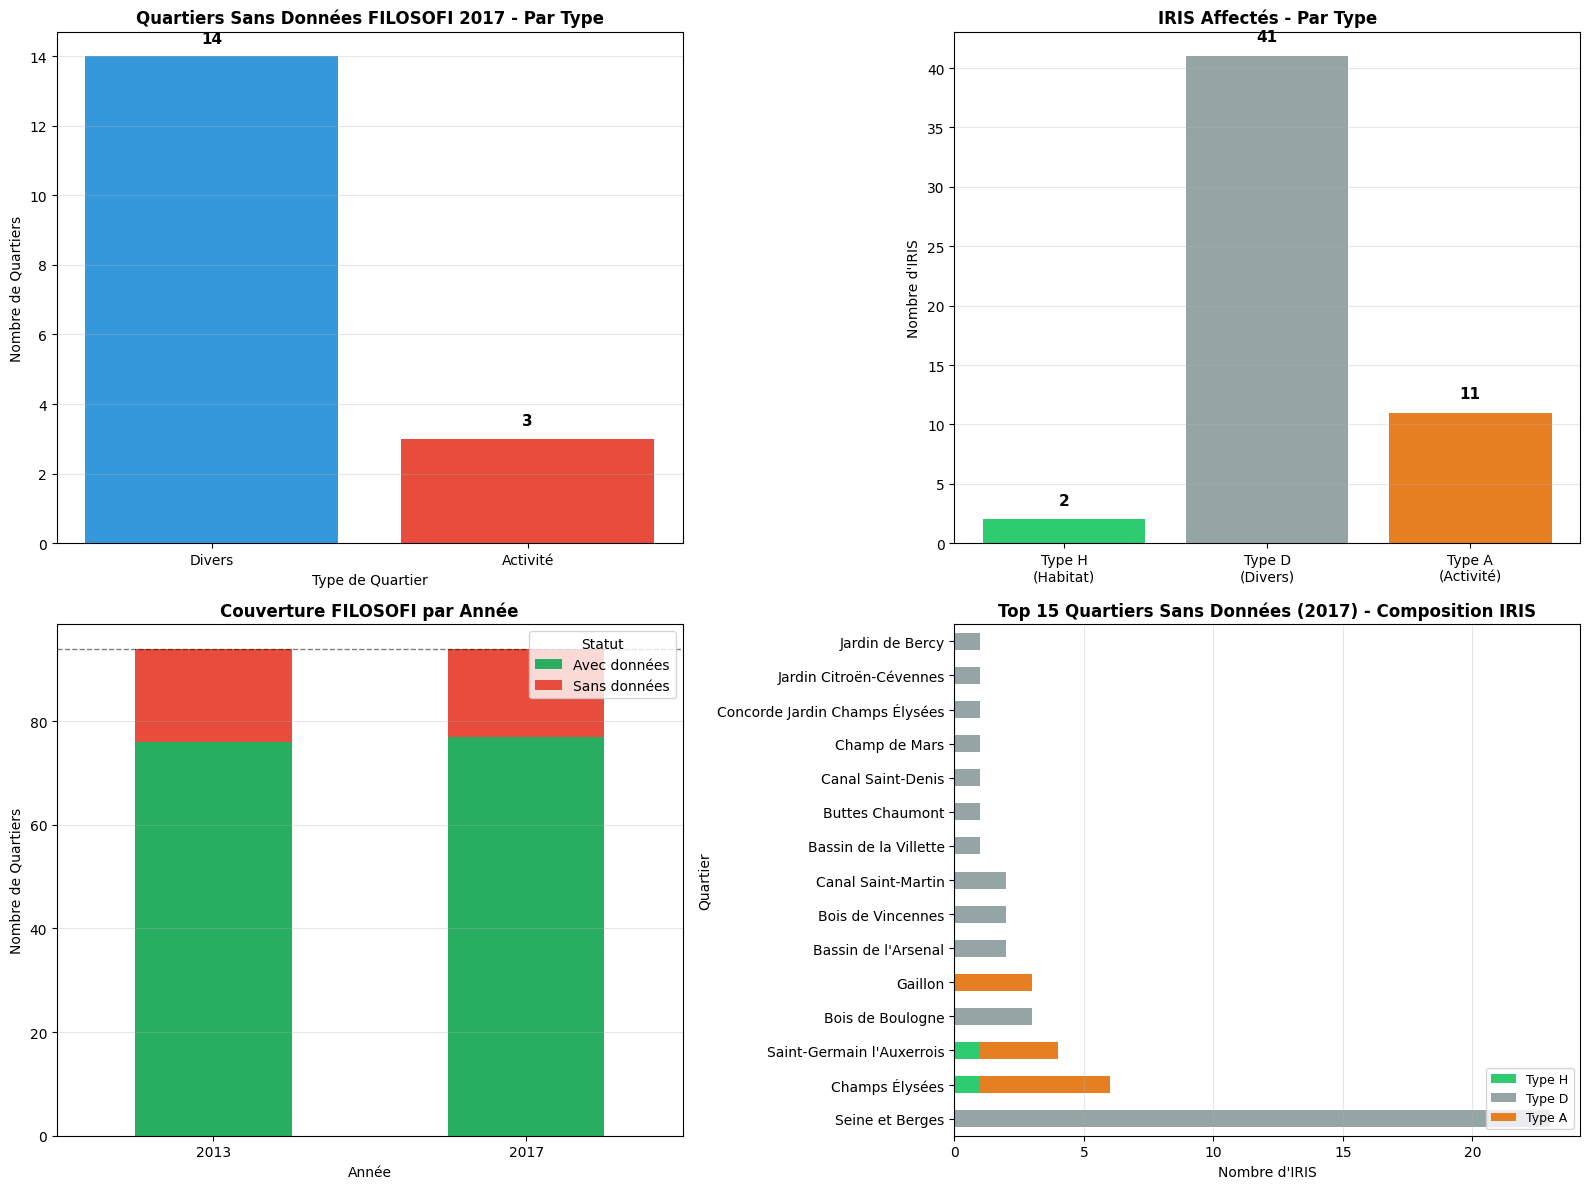

✓ Visualizations complete


In [16]:
# Visualization of missing quartiers
print("\nCreating visualizations...\n")

# Use 2017 missing data for visualization
missing_quartiers = all_quartiers - filosofi_2017_quartiers
missing_info = quartier_iris_types[quartier_iris_types['quartier'].isin(missing_quartiers)].copy()

if len(missing_quartiers) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Chart 1: Missing quartiers by type (2017)
    type_counts = missing_info['type_quartier'].value_counts()
    axes[0, 0].bar(type_counts.index, type_counts.values, color=['#3498db', '#e74c3c', '#f39c12'])
    axes[0, 0].set_title('Quartiers Sans Données FILOSOFI 2017 - Par Type', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Type de Quartier')
    axes[0, 0].set_ylabel('Nombre de Quartiers')
    axes[0, 0].grid(axis='y', alpha=0.3)
    for i, (idx, val) in enumerate(type_counts.items()):
        axes[0, 0].text(i, val + 0.3, str(val), ha='center', va='bottom', fontweight='bold', fontsize=11)
    
    # Chart 2: IRIS composition of missing quartiers
    iris_data = {
        'Type H\n(Habitat)': missing_info['n_iris_H'].sum(),
        'Type D\n(Divers)': missing_info['n_iris_D'].sum(),
        'Type A\n(Activité)': missing_info['n_iris_A'].sum()
    }
    axes[0, 1].bar(iris_data.keys(), iris_data.values(), color=['#2ecc71', '#95a5a6', '#e67e22'])
    axes[0, 1].set_title('IRIS Affectés - Par Type', fontsize=12, fontweight='bold')
    axes[0, 1].set_ylabel('Nombre d\'IRIS')
    axes[0, 1].grid(axis='y', alpha=0.3)
    for i, (key, val) in enumerate(iris_data.items()):
        axes[0, 1].text(i, val + 1, str(val), ha='center', va='bottom', fontweight='bold', fontsize=11)
    
    # Chart 3: Coverage comparison 2013 vs 2017
    coverage_data = pd.DataFrame({
        'Avec données': [len(filosofi_2013_quartiers), len(filosofi_2017_quartiers)],
        'Sans données': [len(all_quartiers - filosofi_2013_quartiers), len(all_quartiers - filosofi_2017_quartiers)]
    }, index=['2013', '2017'])
    
    coverage_data.plot(kind='bar', stacked=True, ax=axes[1, 0], color=['#27ae60', '#e74c3c'])
    axes[1, 0].set_title('Couverture FILOSOFI par Année', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Année')
    axes[1, 0].set_ylabel('Nombre de Quartiers')
    axes[1, 0].set_xticklabels(['2013', '2017'], rotation=0)
    axes[1, 0].legend(title='Statut', loc='upper right')
    axes[1, 0].grid(axis='y', alpha=0.3)
    axes[1, 0].axhline(y=len(all_quartiers), color='black', linestyle='--', linewidth=1, alpha=0.5, label='Total quartiers')
    
    # Chart 4: Top missing quartiers by total IRIS
    top_missing = missing_info.nlargest(15, 'n_iris_total')[['quartier', 'n_iris_H', 'n_iris_D', 'n_iris_A']].set_index('quartier')
    top_missing.plot(kind='barh', stacked=True, ax=axes[1, 1], 
                     color=['#2ecc71', '#95a5a6', '#e67e22'])
    axes[1, 1].set_title('Top 15 Quartiers Sans Données (2017) - Composition IRIS', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Nombre d\'IRIS')
    axes[1, 1].set_ylabel('Quartier')
    axes[1, 1].legend(['Type H', 'Type D', 'Type A'], loc='lower right', fontsize=9)
    axes[1, 1].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("✓ Visualizations complete")
else:
    print("No missing quartiers to visualize")

## 8. Fusion des Datasets par Année

Créer 3 datasets fusionnés (2013, 2017, 2021) en combinant FILOSOFI, EDUCATION, CENSUS et DVF.

**Note importante:** Pour 2013, on utilise DVF 2014 comme proxy (les données immobilières de l'année suivante reflètent les conditions de 2013).

### 8.1 Préparation des Données DVF par Année

In [17]:
print("Preparing DVF data by year...\n")

# Extract DVF data for specific years
# 2013 → use 2014 as proxy
dvf_2013_proxy = dvf_quartier_clean[dvf_quartier_clean['annee'] == 2014].copy()
dvf_2013_proxy['annee'] = 2013  # Relabel as 2013
print(f"DVF 2013 (proxy from 2014): {len(dvf_2013_proxy)} quartier-year observations")

# 2017 → use 2017
dvf_2017 = dvf_quartier_clean[dvf_quartier_clean['annee'] == 2017].copy()
print(f"DVF 2017: {len(dvf_2017)} quartier-year observations")

# 2021 → use 2021
dvf_2021 = dvf_quartier_clean[dvf_quartier_clean['annee'] == 2021].copy()
print(f"DVF 2021: {len(dvf_2021)} quartier-year observations")

print("\n✓ DVF data prepared by year")

Preparing DVF data by year...

DVF 2013 (proxy from 2014): 81 quartier-year observations
DVF 2017: 81 quartier-year observations
DVF 2021: 80 quartier-year observations

✓ DVF data prepared by year


### 8.2 Fusion des Datasets - Année 2013

In [18]:
print("="*80)
print("MERGING DATASETS - 2013")
print("="*80)

# Start with FILOSOFI 2013
filosofi_2013_year = filosofi_quartier_clean[filosofi_quartier_clean['annee'] == 2013].copy()
print(f"\nFILOSOFI 2013: {len(filosofi_2013_year)} quartiers")

# Merge with EDUCATION 2013
education_2013_year = education_quartier_clean[education_quartier_clean['annee'] == 2013].copy()
merged_2013 = filosofi_2013_year.merge(
    education_2013_year[['quartier', 'pop_bac_sup']],
    on='quartier',
    how='outer',
    suffixes=('', '_edu')
)
print(f"After EDUCATION merge: {len(merged_2013)} quartiers")

# Merge with CENSUS 2013
census_2013_year = census_quartier_clean[census_quartier_clean['annee'] == 2013].copy()
merged_2013 = merged_2013.merge(
    census_2013_year[['quartier', 'pop_total', 'pop_cadres', 'pop_ouvriers', 'pop_25_39', 'pop_65plus', 
                      'pop_immigres', 'pop_15plus', 'pct_cadres', 'pct_ouvriers', 'pct_25_39', 'pct_65plus', 'pct_immigres']],
    on='quartier',
    how='outer',
    suffixes=('', '_census')
)
print(f"After CENSUS merge: {len(merged_2013)} quartiers")

# Merge with DVF 2013 (proxy from 2014)
merged_2013 = merged_2013.merge(
    dvf_2013_proxy[['quartier', 'prix_m2_mean', 'prix_m2_median', 'n_transactions']],
    on='quartier',
    how='left'  # Left join because not all quartiers have DVF data
)
print(f"After DVF merge: {len(merged_2013)} quartiers")

# Add quartier type classification
merged_2013 = merged_2013.merge(
    quartier_iris_types[['quartier', 'type_quartier', 'pct_H']],
    on='quartier',
    how='left'
)

# Ensure year column
merged_2013['annee'] = 2013

# Reorder columns
column_order = ['quartier', 'annee', 'type_quartier', 'pct_H', 'n_iris_H', 'n_iris_D', 'n_iris_A', 'n_iris_total',
                'median_uc', 'pop_bac_sup', 'pop_total', 'pop_cadres', 'pop_ouvriers', 'pop_25_39', 'pop_65plus',
                'pop_immigres', 'pop_15plus', 'pct_cadres', 'pct_ouvriers', 'pct_25_39', 'pct_65plus', 'pct_immigres', 
                'prix_m2_mean', 'prix_m2_median', 'n_transactions']
# Add n_iris column if it exists
if 'n_iris' in merged_2013.columns:
    merged_2013 = merged_2013.drop(columns=['n_iris'])

merged_2013 = merged_2013[column_order]

print(f"\n✓ Dataset 2013 merged successfully")
print(f"  Total quartiers: {len(merged_2013)}")
print(f"  Columns: {len(merged_2013.columns)}")
print(f"\nSample:")
print(merged_2013.head())

MERGING DATASETS - 2013

FILOSOFI 2013: 76 quartiers
After EDUCATION merge: 94 quartiers
After CENSUS merge: 94 quartiers
After DVF merge: 94 quartiers

✓ Dataset 2013 merged successfully
  Total quartiers: 94
  Columns: 25

Sample:
              quartier  annee type_quartier  pct_H  n_iris_H  n_iris_D  \
0             Amérique   2013    Habitation  96.00     24.00      0.00   
1              Arsenal   2013    Habitation 100.00      4.00      0.00   
2      Arts et Métiers   2013    Habitation 100.00      5.00      0.00   
3              Auteuil   2013    Habitation  96.77     30.00      0.00   
4  Bassin de l'Arsenal   2013        Divers   0.00       NaN       NaN   

   n_iris_A  n_iris_total  median_uc  pop_bac_sup  pop_total  pop_cadres  \
0      1.00         25.00   20614.11     16904.38   57481.80     9091.50   
1      0.00          4.00   33392.71      4084.70    8474.82     2334.44   
2      0.00          5.00   27563.00      4756.00    9800.73     3237.21   
3      1.00       

### 8.3 Fusion des Datasets - Année 2017

In [19]:
print("="*80)
print("MERGING DATASETS - 2017")
print("="*80)

# Start with FILOSOFI 2017
filosofi_2017_year = filosofi_quartier_clean[filosofi_quartier_clean['annee'] == 2017].copy()
print(f"\nFILOSOFI 2017: {len(filosofi_2017_year)} quartiers")

# Merge with EDUCATION 2017
education_2017_year = education_quartier_clean[education_quartier_clean['annee'] == 2017].copy()
merged_2017 = filosofi_2017_year.merge(
    education_2017_year[['quartier', 'pop_bac_sup']],
    on='quartier',
    how='outer',
    suffixes=('', '_edu')
)
print(f"After EDUCATION merge: {len(merged_2017)} quartiers")

# Merge with CENSUS 2017
census_2017_year = census_quartier_clean[census_quartier_clean['annee'] == 2017].copy()
merged_2017 = merged_2017.merge(
    census_2017_year[['quartier', 'pop_total', 'pop_cadres', 'pop_ouvriers', 'pop_25_39', 'pop_65plus',
                      'pop_immigres', 'pop_15plus', 'pct_cadres', 'pct_ouvriers', 'pct_25_39', 'pct_65plus', 'pct_immigres']],
    on='quartier',
    how='outer',
    suffixes=('', '_census')
)
print(f"After CENSUS merge: {len(merged_2017)} quartiers")

# Merge with DVF 2017
merged_2017 = merged_2017.merge(
    dvf_2017[['quartier', 'prix_m2_mean', 'prix_m2_median', 'n_transactions']],
    on='quartier',
    how='left'
)
print(f"After DVF merge: {len(merged_2017)} quartiers")

# Add quartier type classification
merged_2017 = merged_2017.merge(
    quartier_iris_types[['quartier', 'type_quartier', 'pct_H']],
    on='quartier',
    how='left'
)

# Ensure year column
merged_2017['annee'] = 2017

# Reorder columns
column_order = ['quartier', 'annee', 'type_quartier', 'pct_H', 'n_iris_H', 'n_iris_D', 'n_iris_A', 'n_iris_total',
                'median_uc', 'pop_bac_sup', 'pop_total', 'pop_cadres', 'pop_ouvriers', 'pop_25_39', 'pop_65plus',
                'pop_immigres', 'pop_15plus', 'pct_cadres', 'pct_ouvriers', 'pct_25_39', 'pct_65plus', 'pct_immigres',
                'prix_m2_mean', 'prix_m2_median', 'n_transactions']
if 'n_iris' in merged_2017.columns:
    merged_2017 = merged_2017.drop(columns=['n_iris'])

merged_2017 = merged_2017[column_order]

print(f"\n✓ Dataset 2017 merged successfully")
print(f"  Total quartiers: {len(merged_2017)}")
print(f"  Columns: {len(merged_2017.columns)}")
print(f"\nSample:")
print(merged_2017.head())

MERGING DATASETS - 2017

FILOSOFI 2017: 77 quartiers
After EDUCATION merge: 94 quartiers
After CENSUS merge: 94 quartiers
After DVF merge: 94 quartiers

✓ Dataset 2017 merged successfully
  Total quartiers: 94
  Columns: 25

Sample:
              quartier  annee type_quartier  pct_H  n_iris_H  n_iris_D  \
0             Amérique   2017    Habitation  96.00     24.00      0.00   
1              Arsenal   2017    Habitation 100.00      4.00      0.00   
2      Arts et Métiers   2017    Habitation 100.00      5.00      0.00   
3              Auteuil   2017    Habitation  96.77     30.00      0.00   
4  Bassin de l'Arsenal   2017        Divers   0.00       NaN       NaN   

   n_iris_A  n_iris_total  median_uc  pop_bac_sup  pop_total  pop_cadres  \
0      1.00         25.00   21595.00     19110.87   58261.22     9806.23   
1      0.00          4.00   34495.00      4651.34    8917.87     2471.84   
2      0.00          5.00   30610.00      4920.24    9556.03     2998.40   
3      1.00       

### 8.4 Fusion des Datasets - Année 2021

In [20]:
print("="*80)
print("MERGING DATASETS - 2021")
print("="*80)

# Start with FILOSOFI 2021
filosofi_2021_year = filosofi_quartier_clean[filosofi_quartier_clean['annee'] == 2021].copy()
print(f"\nFILOSOFI 2021: {len(filosofi_2021_year)} quartiers")

# Merge with EDUCATION 2021
education_2021_year = education_quartier_clean[education_quartier_clean['annee'] == 2021].copy()
merged_2021 = filosofi_2021_year.merge(
    education_2021_year[['quartier', 'pop_bac_sup']],
    on='quartier',
    how='outer',
    suffixes=('', '_edu')
)
print(f"After EDUCATION merge: {len(merged_2021)} quartiers")

# Merge with CENSUS 2021
census_2021_year = census_quartier_clean[census_quartier_clean['annee'] == 2021].copy()
merged_2021 = merged_2021.merge(
    census_2021_year[['quartier', 'pop_total', 'pop_cadres', 'pop_ouvriers', 'pop_25_39', 'pop_65plus',
                      'pop_immigres', 'pop_15plus', 'pct_cadres', 'pct_ouvriers', 'pct_25_39', 'pct_65plus', 'pct_immigres']],
    on='quartier',
    how='outer',
    suffixes=('', '_census')
)
print(f"After CENSUS merge: {len(merged_2021)} quartiers")

# Merge with DVF 2021
merged_2021 = merged_2021.merge(
    dvf_2021[['quartier', 'prix_m2_mean', 'prix_m2_median', 'n_transactions']],
    on='quartier',
    how='left'
)
print(f"After DVF merge: {len(merged_2021)} quartiers")

# Add quartier type classification
merged_2021 = merged_2021.merge(
    quartier_iris_types[['quartier', 'type_quartier', 'pct_H']],
    on='quartier',
    how='left'
)

# Ensure year column
merged_2021['annee'] = 2021

# Reorder columns
column_order = ['quartier', 'annee', 'type_quartier', 'pct_H', 'n_iris_H', 'n_iris_D', 'n_iris_A', 'n_iris_total',
                'median_uc', 'pop_bac_sup', 'pop_total', 'pop_cadres', 'pop_ouvriers', 'pop_25_39', 'pop_65plus',
                'pop_immigres', 'pop_15plus', 'pct_cadres', 'pct_ouvriers', 'pct_25_39', 'pct_65plus', 'pct_immigres',
                'prix_m2_mean', 'prix_m2_median', 'n_transactions']
if 'n_iris' in merged_2021.columns:
    merged_2021 = merged_2021.drop(columns=['n_iris'])

merged_2021 = merged_2021[column_order]

print(f"\n✓ Dataset 2021 merged successfully")
print(f"  Total quartiers: {len(merged_2021)}")
print(f"  Columns: {len(merged_2021.columns)}")
print(f"\nSample:")
print(merged_2021.head())

MERGING DATASETS - 2021

FILOSOFI 2021: 94 quartiers
After EDUCATION merge: 94 quartiers
After CENSUS merge: 94 quartiers
After DVF merge: 94 quartiers

✓ Dataset 2021 merged successfully
  Total quartiers: 94
  Columns: 25

Sample:
              quartier  annee type_quartier  pct_H  n_iris_H  n_iris_D  \
0             Amérique   2021    Habitation  96.00        24         0   
1              Arsenal   2021    Habitation 100.00         4         0   
2      Arts et Métiers   2021    Habitation 100.00         5         0   
3              Auteuil   2021    Habitation  96.77        30         0   
4  Bassin de l'Arsenal   2021        Divers   0.00         0         2   

   n_iris_A  n_iris_total  median_uc  pop_bac_sup  pop_total  pop_cadres  \
0         1            25   24610.00     20017.89   57165.27    10445.82   
1         0             4   36735.00      4686.37    9042.63     2461.65   
2         0             5   33520.00      4989.50    8902.05     3221.35   
3         1       

### 8.5 Vérification des Datasets Fusionnés

In [23]:
print("="*80)
print("MERGED DATASETS VERIFICATION")
print("="*80)

# Check data completeness for each year
for year, df in [(2013, merged_2013), (2017, merged_2017), (2021, merged_2021)]:
    print(f"\n{'='*80}")
    print(f"YEAR {year}")
    print(f"{'='*80}")
    print(f"Total quartiers: {len(df)}")
    print(f"Quartiers type Habitation: {(df['type_quartier'] == 'Habitation').sum()}")
    print(f"Quartiers type Divers: {(df['type_quartier'] == 'Divers').sum()}")
    print(f"Quartiers type Activité: {(df['type_quartier'] == 'Activité').sum()}")
    
    print(f"\nData completeness:")
    print(f"  median_uc (FILOSOFI):    {df['median_uc'].notna().sum()} / {len(df)} ({df['median_uc'].notna().sum()/len(df)*100:.1f}%)")
    print(f"  pop_bac_sup (EDUCATION): {df['pop_bac_sup'].notna().sum()} / {len(df)} ({df['pop_bac_sup'].notna().sum()/len(df)*100:.1f}%)")
    print(f"  pop_total (CENSUS):      {df['pop_total'].notna().sum()} / {len(df)} ({df['pop_total'].notna().sum()/len(df)*100:.1f}%)")
    print(f"  pop_ouvriers (CENSUS):   {df['pop_ouvriers'].notna().sum()} / {len(df)} ({df['pop_ouvriers'].notna().sum()/len(df)*100:.1f}%)")
    print(f"  pop_25_39 (CENSUS):      {df['pop_25_39'].notna().sum()} / {len(df)} ({df['pop_25_39'].notna().sum()/len(df)*100:.1f}%)")
    print(f"  pop_65plus (CENSUS):     {df['pop_65plus'].notna().sum()} / {len(df)} ({df['pop_65plus'].notna().sum()/len(df)*100:.1f}%)")
    print(f"  prix_m2_median (DVF):    {df['prix_m2_median'].notna().sum()} / {len(df)} ({df['prix_m2_median'].notna().sum()/len(df)*100:.1f}%)")
    
    # Check completeness for Habitation quartiers only
    habitation_df = df[df['type_quartier'] == 'Habitation']
    print(f"\nFor Habitation quartiers only ({len(habitation_df)} quartiers):")
    print(f"  median_uc (FILOSOFI):    {habitation_df['median_uc'].notna().sum()} / {len(habitation_df)} ({habitation_df['median_uc'].notna().sum()/len(habitation_df)*100:.1f}%)")
    print(f"  pop_bac_sup (EDUCATION): {habitation_df['pop_bac_sup'].notna().sum()} / {len(habitation_df)} ({habitation_df['pop_bac_sup'].notna().sum()/len(habitation_df)*100:.1f}%)")
    print(f"  pop_total (CENSUS):      {habitation_df['pop_total'].notna().sum()} / {len(habitation_df)} ({habitation_df['pop_total'].notna().sum()/len(habitation_df)*100:.1f}%)")
    print(f"  pop_ouvriers (CENSUS):   {habitation_df['pop_ouvriers'].notna().sum()} / {len(habitation_df)} ({habitation_df['pop_ouvriers'].notna().sum()/len(habitation_df)*100:.1f}%)")
    print(f"  pop_25_39 (CENSUS):      {habitation_df['pop_25_39'].notna().sum()} / {len(habitation_df)} ({habitation_df['pop_25_39'].notna().sum()/len(habitation_df)*100:.1f}%)")
    print(f"  pop_65plus (CENSUS):     {habitation_df['pop_65plus'].notna().sum()} / {len(habitation_df)} ({habitation_df['pop_65plus'].notna().sum()/len(habitation_df)*100:.1f}%)")
    print(f"  prix_m2_median (DVF):    {habitation_df['prix_m2_median'].notna().sum()} / {len(habitation_df)} ({habitation_df['prix_m2_median'].notna().sum()/len(habitation_df)*100:.1f}%)")

print(f"\n{'='*80}")
print("✓ Verification complete")
print(f"{'='*80}")

MERGED DATASETS VERIFICATION

YEAR 2013
Total quartiers: 94
Quartiers type Habitation: 71
Quartiers type Divers: 14
Quartiers type Activité: 9

Data completeness:
  median_uc (FILOSOFI):    76 / 94 (80.9%)
  pop_bac_sup (EDUCATION): 94 / 94 (100.0%)
  pop_total (CENSUS):      94 / 94 (100.0%)
  pop_ouvriers (CENSUS):   94 / 94 (100.0%)
  pop_25_39 (CENSUS):      94 / 94 (100.0%)
  pop_65plus (CENSUS):     94 / 94 (100.0%)
  prix_m2_median (DVF):    81 / 94 (86.2%)

For Habitation quartiers only (71 quartiers):
  median_uc (FILOSOFI):    71 / 71 (100.0%)
  pop_bac_sup (EDUCATION): 71 / 71 (100.0%)
  pop_total (CENSUS):      71 / 71 (100.0%)
  pop_ouvriers (CENSUS):   71 / 71 (100.0%)
  pop_25_39 (CENSUS):      71 / 71 (100.0%)
  pop_65plus (CENSUS):     71 / 71 (100.0%)
  prix_m2_median (DVF):    71 / 71 (100.0%)

YEAR 2017
Total quartiers: 94
Quartiers type Habitation: 71
Quartiers type Divers: 14
Quartiers type Activité: 9

Data completeness:
  median_uc (FILOSOFI):    77 / 94 (81.9%)

### 8.6 Sauvegarde des Datasets Fusionnés

In [24]:
print("Filtering for HABITATION quartiers only (>50% H)...\n")

# Filter each year to keep only Habitation quartiers
merged_2013_habitation = merged_2013[merged_2013['type_quartier'] == 'Habitation'].copy()
merged_2017_habitation = merged_2017[merged_2017['type_quartier'] == 'Habitation'].copy()
merged_2021_habitation = merged_2021[merged_2021['type_quartier'] == 'Habitation'].copy()

print(f"2013: {len(merged_2013)} → {len(merged_2013_habitation)} quartiers (Habitation only)")
print(f"2017: {len(merged_2017)} → {len(merged_2017_habitation)} quartiers (Habitation only)")
print(f"2021: {len(merged_2021)} → {len(merged_2021_habitation)} quartiers (Habitation only)")

print("\n" + "="*80)
print("DATA COMPLETENESS ANALYSIS - HABITATION QUARTIERS ONLY")
print("="*80)

for year, df in [(2013, merged_2013_habitation), (2017, merged_2017_habitation), (2021, merged_2021_habitation)]:
    print(f"\n{'='*80}")
    print(f"YEAR {year} - {len(df)} Habitation Quartiers")
    print(f"{'='*80}")
    
    # Count complete vs missing for each variable
    print(f"\nData availability:")
    print(f"  median_uc (FILOSOFI):    {df['median_uc'].notna().sum():>2} / {len(df)} ({df['median_uc'].notna().sum()/len(df)*100:>5.1f}%)")
    print(f"  pop_bac_sup (EDUCATION): {df['pop_bac_sup'].notna().sum():>2} / {len(df)} ({df['pop_bac_sup'].notna().sum()/len(df)*100:>5.1f}%)")
    print(f"  pop_total (CENSUS):      {df['pop_total'].notna().sum():>2} / {len(df)} ({df['pop_total'].notna().sum()/len(df)*100:>5.1f}%)")
    print(f"  pop_ouvriers (CENSUS):   {df['pop_ouvriers'].notna().sum():>2} / {len(df)} ({df['pop_ouvriers'].notna().sum()/len(df)*100:>5.1f}%)")
    print(f"  pop_25_39 (CENSUS):      {df['pop_25_39'].notna().sum():>2} / {len(df)} ({df['pop_25_39'].notna().sum()/len(df)*100:>5.1f}%)")
    print(f"  pop_65plus (CENSUS):     {df['pop_65plus'].notna().sum():>2} / {len(df)} ({df['pop_65plus'].notna().sum()/len(df)*100:>5.1f}%)")
    print(f"  pct_cadres (CENSUS):     {df['pct_cadres'].notna().sum():>2} / {len(df)} ({df['pct_cadres'].notna().sum()/len(df)*100:>5.1f}%)")
    print(f"  pct_ouvriers (CENSUS):   {df['pct_ouvriers'].notna().sum():>2} / {len(df)} ({df['pct_ouvriers'].notna().sum()/len(df)*100:>5.1f}%)")
    print(f"  pct_25_39 (CENSUS):      {df['pct_25_39'].notna().sum():>2} / {len(df)} ({df['pct_25_39'].notna().sum()/len(df)*100:>5.1f}%)")
    print(f"  pct_65plus (CENSUS):     {df['pct_65plus'].notna().sum():>2} / {len(df)} ({df['pct_65plus'].notna().sum()/len(df)*100:>5.1f}%)")
    print(f"  pct_immigres (CENSUS):   {df['pct_immigres'].notna().sum():>2} / {len(df)} ({df['pct_immigres'].notna().sum()/len(df)*100:>5.1f}%)")
    print(f"  prix_m2_median (DVF):    {df['prix_m2_median'].notna().sum():>2} / {len(df)} ({df['prix_m2_median'].notna().sum()/len(df)*100:>5.1f}%)")
    
    # Count quartiers with complete data for all key variables
    complete_filosofi = df['median_uc'].notna()
    complete_education = df['pop_bac_sup'].notna()
    complete_census = df[['pop_total', 'pop_ouvriers', 'pop_25_39', 'pop_65plus', 
                           'pct_cadres', 'pct_ouvriers', 'pct_25_39', 'pct_65plus', 'pct_immigres']].notna().all(axis=1)
    complete_dvf = df['prix_m2_median'].notna()
    
    all_complete = complete_filosofi & complete_education & complete_census & complete_dvf
    
    print(f"\nQuartiers with ALL data sources complete: {all_complete.sum()} / {len(df)} ({all_complete.sum()/len(df)*100:.1f}%)")
    
    if all_complete.sum() < len(df):
        print(f"\nQuartiers with missing data:")
        missing_df = df[~all_complete][['quartier', 'median_uc', 'pop_bac_sup', 'pop_total', 'pop_ouvriers', 'pop_25_39', 'pop_65plus', 'prix_m2_median']]
        for idx, row in missing_df.iterrows():
            missing_vars = []
            if pd.isna(row['median_uc']): missing_vars.append('FILOSOFI')
            if pd.isna(row['pop_bac_sup']): missing_vars.append('EDUCATION')
            if pd.isna(row['pop_total']): missing_vars.append('CENSUS')
            if pd.isna(row['pop_ouvriers']): missing_vars.append('CENSUS(ouvriers)')
            if pd.isna(row['pop_25_39']): missing_vars.append('CENSUS(25-39)')
            if pd.isna(row['pop_65plus']): missing_vars.append('CENSUS(65+)')
            if pd.isna(row['prix_m2_median']): missing_vars.append('DVF')
            print(f"  - {row['quartier']}: missing {', '.join(missing_vars)}")

print("\n" + "="*80)
print("SAVING HABITATION-ONLY DATASETS")
print("="*80)

# Save each year separately (Habitation only)
merged_2013_habitation.to_parquet(DATASETS_DIR / 'paris_merged_2013.parquet', index=False)
print(f"\n✓ paris_merged_2013.parquet: {len(merged_2013_habitation)} rows, {len(merged_2013_habitation.columns)} columns")

merged_2017_habitation.to_parquet(DATASETS_DIR / 'paris_merged_2017.parquet', index=False)
print(f"✓ paris_merged_2017.parquet: {len(merged_2017_habitation)} rows, {len(merged_2017_habitation.columns)} columns")

merged_2021_habitation.to_parquet(DATASETS_DIR / 'paris_merged_2021.parquet', index=False)
print(f"✓ paris_merged_2021.parquet: {len(merged_2021_habitation)} rows, {len(merged_2021_habitation.columns)} columns")

# Also create a combined dataset with all years (Habitation only)
merged_all_years_habitation = pd.concat([merged_2013_habitation, merged_2017_habitation, merged_2021_habitation], ignore_index=True)
merged_all_years_habitation.to_parquet(DATASETS_DIR / 'paris_merged_all_years.parquet', index=False)
print(f"\n✓ paris_merged_all_years.parquet: {len(merged_all_years_habitation)} rows (all years combined)")

print("\n" + "="*80)
print("ALL DATASETS SAVED - HABITATION QUARTIERS ONLY!")
print("="*80)
print(f"\nFiles created:")
print(f"  1. paris_merged_2013.parquet - {len(merged_2013_habitation)} Habitation quartiers (DVF from 2014 as proxy)")
print(f"  2. paris_merged_2017.parquet - {len(merged_2017_habitation)} Habitation quartiers")
print(f"  3. paris_merged_2021.parquet - {len(merged_2021_habitation)} Habitation quartiers")
print(f"  4. paris_merged_all_years.parquet - {len(merged_all_years_habitation)} total rows (3 years combined)")
print(f"\nColumns: {list(merged_2013_habitation.columns)}")
print(f"\n→ Only quartiers with type_quartier='Habitation' (>50% IRIS Type H) are included")

Filtering for HABITATION quartiers only (>50% H)...

2013: 94 → 71 quartiers (Habitation only)
2017: 94 → 71 quartiers (Habitation only)
2021: 94 → 71 quartiers (Habitation only)

DATA COMPLETENESS ANALYSIS - HABITATION QUARTIERS ONLY

YEAR 2013 - 71 Habitation Quartiers

Data availability:
  median_uc (FILOSOFI):    71 / 71 (100.0%)
  pop_bac_sup (EDUCATION): 71 / 71 (100.0%)
  pop_total (CENSUS):      71 / 71 (100.0%)
  pop_ouvriers (CENSUS):   71 / 71 (100.0%)
  pop_25_39 (CENSUS):      71 / 71 (100.0%)
  pop_65plus (CENSUS):     71 / 71 (100.0%)
  pct_cadres (CENSUS):     71 / 71 (100.0%)
  pct_ouvriers (CENSUS):   71 / 71 (100.0%)
  pct_25_39 (CENSUS):      71 / 71 (100.0%)
  pct_65plus (CENSUS):     71 / 71 (100.0%)
  pct_immigres (CENSUS):   71 / 71 (100.0%)
  prix_m2_median (DVF):    71 / 71 (100.0%)

Quartiers with ALL data sources complete: 71 / 71 (100.0%)

YEAR 2017 - 71 Habitation Quartiers

Data availability:
  median_uc (FILOSOFI):    71 / 71 (100.0%)
  pop_bac_sup (EDUC